In [1]:
import os

# Optional: Only needed if using custom path
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser("C:/Users/Kanishka K/Downloads/.kaggle")

# Use system shell command to download the dataset
!kaggle datasets download -d goyaladi/climate-insights-dataset


Dataset URL: https://www.kaggle.com/datasets/goyaladi/climate-insights-dataset
License(s): CC0-1.0
climate-insights-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile
import os
import pandas as pd

# Define the file paths
zip_path = "climate-insights-dataset.zip"
extract_to = "climate_data"

# Step 1: Extract the zip file
if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f" Files extracted to '{extract_to}' folder.")
else:
    print(f" '{extract_to}' folder already exists. Skipping extraction.")

# Step 2: List files inside the extracted folder (to find the CSV name)
files = os.listdir(extract_to)
print(" Extracted files:", files)

# Step 3: Load the CSV (adjust filename if needed)
for file in files:
    if file.endswith('.csv'):
        csv_path = os.path.join(extract_to, file)
        df = pd.read_csv(csv_path)
        print(f"\n Loaded '{file}' successfully!")
        print("\n First few rows of the dataset:")
        print(df.head())
        break
else:
    print("No CSV file found in the extracted folder.")


 'climate_data' folder already exists. Skipping extraction.
 Extracted files: ['climate_change_data.csv', 'Readme.md']

 Loaded 'climate_change_data.csv' successfully!

 First few rows of the dataset:
                            Date          Location        Country  \
0  2000-01-01 00:00:00.000000000   New Williamtown         Latvia   
1  2000-01-01 20:09:43.258325832      North Rachel   South Africa   
2  2000-01-02 16:19:26.516651665  West Williamland  French Guiana   
3  2000-01-03 12:29:09.774977497       South David        Vietnam   
4  2000-01-04 08:38:53.033303330    New Scottburgh        Moldova   

   Temperature  CO2 Emissions  Sea Level Rise  Precipitation   Humidity  \
0    10.688986     403.118903        0.717506      13.835237  23.631256   
1    13.814430     396.663499        1.205715      40.974084  43.982946   
2    27.323718     451.553155       -0.160783      42.697931  96.652600   
3    12.309581     422.404983       -0.475931       5.193341  47.467938   
4    13.2

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Convert to datetime and add time features
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month
df['dayofyear'] = df['Date'].dt.dayofyear
df['weekday'] = df['Date'].dt.weekday

# Encode location
location_encoder = LabelEncoder()
df['Location_Encoded'] = location_encoder.fit_transform(df['Location'])

# ✅ Now we exclude 'CO2 Emissions' from features because it's the new target
features = ['Temperature', 'Sea Level Rise', 'Precipitation',
            'Humidity', 'Wind Speed', 'month', 'dayofyear', 'weekday']

# These will be the input features (scaled)
climate_data = df[features].values

# This is the categorical input (location)
location_data = df['Location_Encoded'].values.reshape(-1, 1)

# This is the target we want to predict
target_data = df['CO2 Emissions'].values.reshape(-1, 1)


In [4]:
# Concatenate numeric + categorical data (for sequence creation)
full_data = np.hstack([climate_data, location_data, target_data])


In [5]:
def create_sequences(data, seq_length=7, target_index=1):  # 1 = CO2 Emissions
    X_numeric, X_cat, y = [], [], []
    for i in range(len(data) - seq_length):
        X_numeric.append(data[i:i+seq_length, :-1])
        X_cat.append(data[i+seq_length-1, -1])  # Location at final step
        y.append(data[i+seq_length][target_index])  # New target
    return np.array(X_numeric), np.array(X_cat), np.array(y)


In [6]:
X_numeric, X_cat, y = create_sequences(full_data, seq_length=7, target_index=-1)


In [7]:
from sklearn.model_selection import train_test_split

X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_numeric, X_cat, y, test_size=0.2, shuffle=False)


In [8]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout, Flatten

# 1. Numeric input: (seq_length, num_features)
numeric_input = Input(shape=(X_num_train.shape[1], X_num_train.shape[2]), name='numeric_input')

# 2. Location input
location_input = Input(shape=(1,), name='location_input')

# 3. Location embedding (dim = 5)
embedding_dim = 5
num_locations = len(np.unique(X_cat_train))
location_embed = Embedding(input_dim=num_locations, output_dim=embedding_dim)(location_input)
location_embed_flat = Flatten()(location_embed)

# 4. LSTM block for numeric input
lstm_out = LSTM(64, return_sequences=True)(numeric_input)
lstm_out = LSTM(32)(lstm_out)

# 5. Combine LSTM + location embedding
combined = Concatenate()([lstm_out, location_embed_flat])
dense1 = Dense(64, activation='relu')(combined)
dropout = Dropout(0.3)(dense1)
output = Dense(1)(dropout)

# 6. Build model
model = Model(inputs=[numeric_input, location_input], outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numeric_input       │ (None, 7, 9)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ location_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 64)     │     18,944 │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 5)      │     39,970 │ location_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 5)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 37)        │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,432 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,827 (288.39 KB)

 Trainable params: 73,827 (288.39 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    {'numeric_input': X_num_train, 'location_input': X_cat_train},
    y_train,
    validation_data=({'numeric_input': X_num_test, 'location_input': X_cat_test}, y_test),
    epochs=25,
    batch_size=32
)


Epoch 1/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 147359.0469 - val_loss: 67418.0234
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 45064.6562 - val_loss: 4992.2510
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6072.6484 - val_loss: 2576.9404
Epoch 4/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5195.9062 - val_loss: 2545.7534
Epoch 5/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5073.1167 - val_loss: 2520.5015
Epoch 6/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5264.3252 - val_loss: 2565.3728
Epoch 7/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4823.7891 - val_loss: 2546.2942
Epoch 8/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5000.7344 - val_loss: 2576.1841
Epoch 9/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5300.7749 - val_loss: 2565.0754
Epoch 10/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5357.6738 - val_loss: 2522.5945
Epoch 11/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5171.1660 - va

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
📊 CO₂ MSE: 2549.0947
📊 CO₂ R² Score: -0.0282


C:\Users\Kanishka K\PycharmProjects\AIDeaseEarlyprediction\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


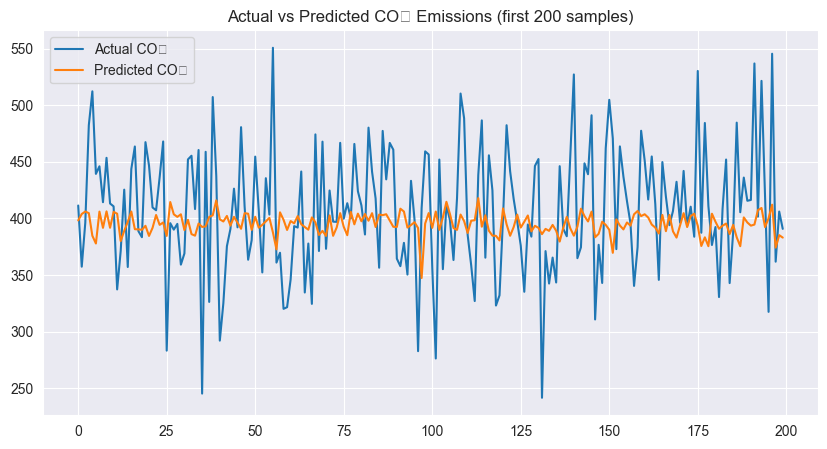

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict
y_pred = model.predict({'numeric_input': X_num_test, 'location_input': X_cat_test})

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 CO₂ MSE: {mse:.4f}")
print(f"📊 CO₂ R² Score: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test[:200], label='Actual CO₂')
plt.plot(y_pred[:200], label='Predicted CO₂')
plt.title("Actual vs Predicted CO₂ Emissions (first 200 samples)")
plt.legend()
plt.show()


In [11]:
y_pred = model.predict({'numeric_input': X_num_test, 'location_input': X_cat_test})

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 CO2 MSE: {mse:.4f}")
print(f"📊 CO2 R² Score: {r2:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
📊 CO2 MSE: 2549.0947
📊 CO2 R² Score: -0.0282
